# **7PAM2005-0105-2024 - Data Mining and Discovery**

### Report submitted by Keerthivasan Kannan (23052162)

## **Gamma vs Hadron Classification in the MAGIC Gamma Telescope dataset**

### **1. Importing necessary libraries**

In [232]:
import re # pip install re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

### **2. Deep cleaning the magic04.names file**

* The code firstly accesses the **magic04.names** file for possibly containing metadata descriptions about the attributes.
* In each line, it removes all punctuation while converting all characters to lowercase to enhance keyword matching accuracy.
* It conducts a search for attribute-related keyword phrases including "length", "width" etc. throughout the bathed text to determine what features exist in the file.
* The analysed keywords get transformed into actual column names present in the dataset through pretty simple translations **("length" -> "fLength")**.
* The code adds "fConc1" as a column name after "fConc" only when this name is absent, it's because the dataset contains both elements.
* Finally we will load the **magic04.data CSV file** by using the prepared column names in a DataFrame.

In [285]:
names_path = "magic04.names"

with open(names_path, "r") as file:
    raw_lines = file.readlines()
    
normalized_lines = [re.sub(r'[^a-zA-Z0-9]', '', line).lower() for line in raw_lines]
attribute_keywords = ["length", "width", "size", "conc", "asym", "m3long", "m3trans", "alpha", "dist", "class"]
matched_attributes = []

for keyword in attribute_keywords:
    for line in normalized_lines:
        if keyword in line and keyword not in matched_attributes:
            matched_attributes.append(keyword)

attribute_mapping = {
    "length": "fLength",
    "width": "fWidth",
    "size": "fSize",
    "conc": "fConc",
    "asym": "fAsym",
    "m3long": "fM3Long",
    "m3trans": "fM3Trans",
    "alpha": "fAlpha",
    "dist": "fDist",
    "class": "Class"
}

column_names = [attribute_mapping[attr] for attr in matched_attributes if attr in attribute_mapping]

if "fConc" in column_names and "fConc1" not in column_names:
    column_names.insert(column_names.index("fConc") + 1, "fConc1")
    
df = pd.read_csv("magic04.data", header=None, names=column_names)
df.head()


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


### **3. Feature Description**

* **fLength**:                  continuous  **(major axis of ellipse [mm])**
* **fWidth**:                   continuous  **(minor axis of ellipse [mm])**
* **fSize**:                    continuous  **(10-log of sum of content of all pixels [in #phot])**
* **fConc**:                    continuous  **(ratio of sum of two highest pixels over fSize  [ratio])**
* **fConc1**:                   continuous  **(ratio of highest pixel over fSize  [ratio])**
* **fAsym**:                    continuous  **(distance from highest pixel to center, projected onto major axis [mm])**
* **fM3Long**:                  continuous  **(3rd root of third moment along major axis  [mm])**
* **fM3Trans**:                 continuous  **(3rd root of third moment along minor axis  [mm])**
* **fAlpha**:                   continuous  **(angle of major axis with vector to origin [deg])**
* **fDist**:                    continuous  **(distance from origin to center of ellipse [mm])**
* **Class**:                    g,h         **(gamma (signal), hadron (background))**


### **4. Dataset Overview**

This code converts class labels to **1 (Gamma) and 0 (Hadron)**, prints the dataset shape and class distribution, then gives a quick statistical overview of all features.

In [291]:
df['Class'] = df['Class'].map({'g': 1, 'h': 0})  # g = gamma (signal), h = hadron (background)
print(f"Dataset shape: {df.shape}")
print(df['Class'].value_counts(normalize=True).rename({1: 'Gamma', 0: 'Hadron'}))
df.describe().T

Dataset shape: (19020, 11)
Class
Gamma     0.64837
Hadron    0.35163
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
fLength,19020.0,53.250154,42.364855,4.2835,24.336000,37.14770,70.122175,334.1770
fWidth,19020.0,22.180966,18.346056,0.0000,11.863800,17.13990,24.739475,256.3820
fSize,19020.0,2.825017,0.472599,1.9413,2.477100,2.73960,3.101600,5.3233
fConc,19020.0,0.380327,0.182813,0.0131,0.235800,0.35415,0.503700,0.8930
fConc1,19020.0,0.214657,0.110511,0.0003,0.128475,0.19650,0.285225,0.6752
fAsym,19020.0,-4.331745,59.206062,-457.9161,-20.586550,4.01305,24.063700,575.2407
fM3Long,19020.0,10.545545,51.000118,-331.7800,-12.842775,15.31410,35.837800,238.3210
fM3Trans,19020.0,0.249726,20.827439,-205.8947,-10.849375,0.66620,10.946425,179.8510
fAlpha,19020.0,27.645707,26.103621,0.0000,5.547925,17.67950,45.883550,90.0000
fDist,19020.0,193.818026,74.731787,1.2826,142.492250,191.85145,240.563825,495.5610


### **5. Class Distribution of Gamma vs Hadron classes**

In [314]:
def plot_class_distribution(dataframe):
    """
    Creates a histogram showing the distribution of Gamma vs Hadron classes.
    
    """  
    fig = px.histogram(dataframe, x='Class', color='Class', color_discrete_sequence=px.colors.sequential.RdBu, 
                       title="Class Distribution: Gamma vs Hadron", text_auto=True)
    fig.update_layout(height=700, bargap=0.2, xaxis_title="Class", yaxis_title="Count", yaxis=dict(dtick=2000),
                      xaxis=dict(tickmode='array', tickvals=[1, 0], ticktext=['Gamma', 'Hadron']),legend=dict(title='Class'))
    fig.for_each_trace(lambda t: t.update(name='g' if t.name == '1' else 'h'))
    return fig

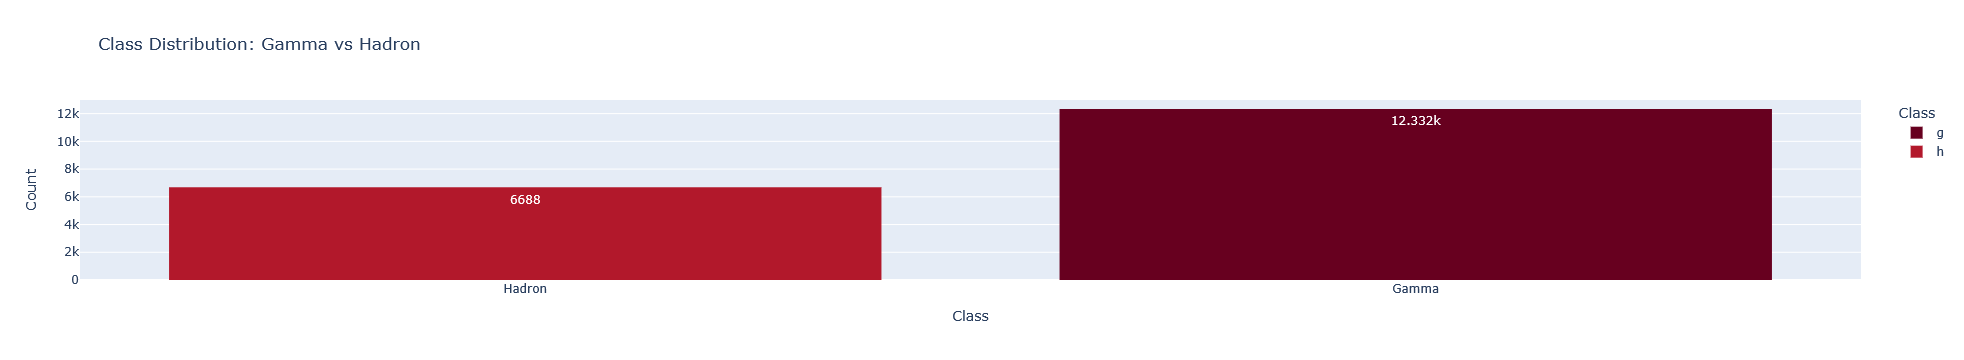

In [303]:
plot_class_distribution(df)

### **6. Correlation Heatmap**

In [305]:
def plot_correlation_map(dataframe):
    """
    Creates a heatmap showing pairwise correlations between numerical features.
    
    """
    corr = dataframe.drop('Class', axis=1).corr()
    fig = go.Figure(data=go.Heatmap(z=corr.values, x=corr.columns, y=corr.columns, colorscale='RdBu', zmin=-1, zmax=1,
                                    text=np.round(corr.values, 2), texttemplate='%{text}', textfont={"size": 12, "color": "black"}))
    fig.update_layout(title='Feature Correlation Heatmap', xaxis_title="Features",
                      yaxis_title="Features", width=800, height=700)
    return fig

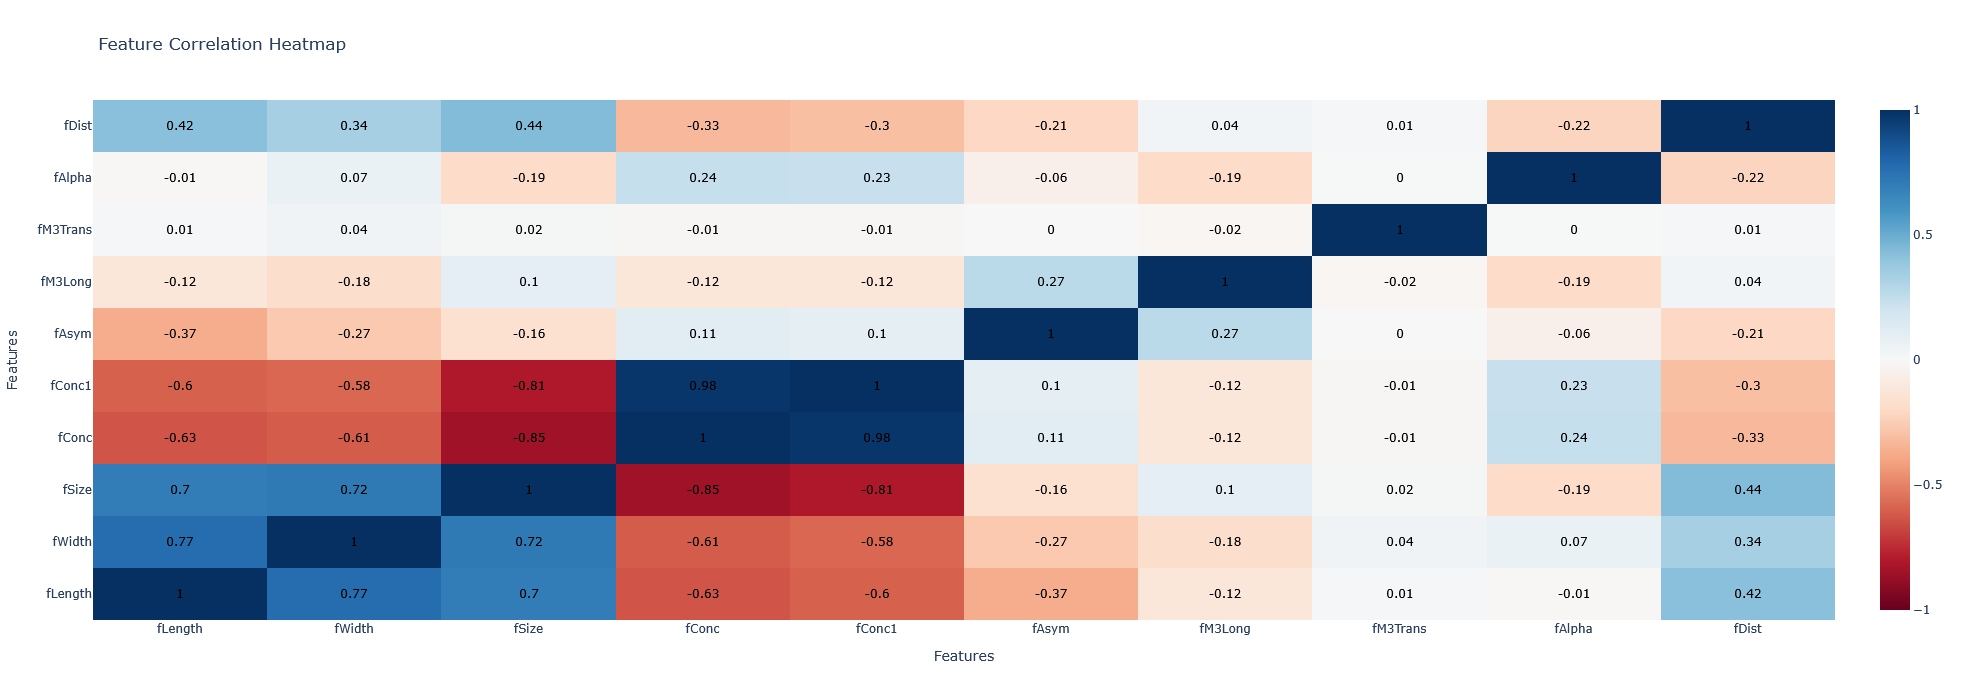

In [307]:
plot_correlation_map(df)

### **7. Data Preprocessing**

We split the data into training and test sets while keeping the class balance intact. Then we scale the features so that logistic regression doesn’t get thrown off by differing value ranges.

In [309]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **8. Training the model and doing prediction**

We will train three models, **Logistic Regression, Decision Tree, and Random Forest** using the training data (scaled only for logistic regression). Then we generate predictions and class probabilities for each model on the test set, adjusting for scaling where needed.

In [318]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

models["Logistic Regression"].fit(X_train_scaled, y_train)
models["Decision Tree"].fit(X_train, y_train)
models["Random Forest"].fit(X_train, y_train)

preds = {name: model.predict(X_test_scaled if name == "Logistic Regression" else X_test) for name, model in models.items()}
probs = {name: model.predict_proba(X_test_scaled if name == "Logistic Regression" else X_test)[:, 1] for name, model in models.items()}

### **9. Evaluating the model with summary**

In [321]:
def model_scores(name, y_true, y_pred, y_proba):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_proba)
    }

results = [model_scores(name, y_test, preds[name], probs[name]) for name in models]
results_df = pd.DataFrame(results).set_index("Model").round(4)
results_df


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Logistic Regression,0.7813,0.7927,0.8973,0.8418,0.8275
Decision Tree,0.8211,0.8653,0.8576,0.8614,0.8057
Random Forest,0.8833,0.8862,0.9408,0.9127,0.9351


### **10. Comparing with the ROC Curve**

In [324]:
def plot_roc_curves(y_test, probs, models):
    """
    Plots ROC curves to compare the performance of multiple classification models.
    
    """
    
    fig = go.Figure()
    for name in models:
        fpr, tpr, _ = roc_curve(y_test, probs[name])
        fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=name))
    
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Diagonal', line=dict(dash='dash', color='black')))
    fig.update_layout(title="ROC Curve Comparison", xaxis_title="False Positive Rate", yaxis_title="True Positive Rate", 
                      width=800, height=600, legend_title="Model", template="plotly_white")
    return fig

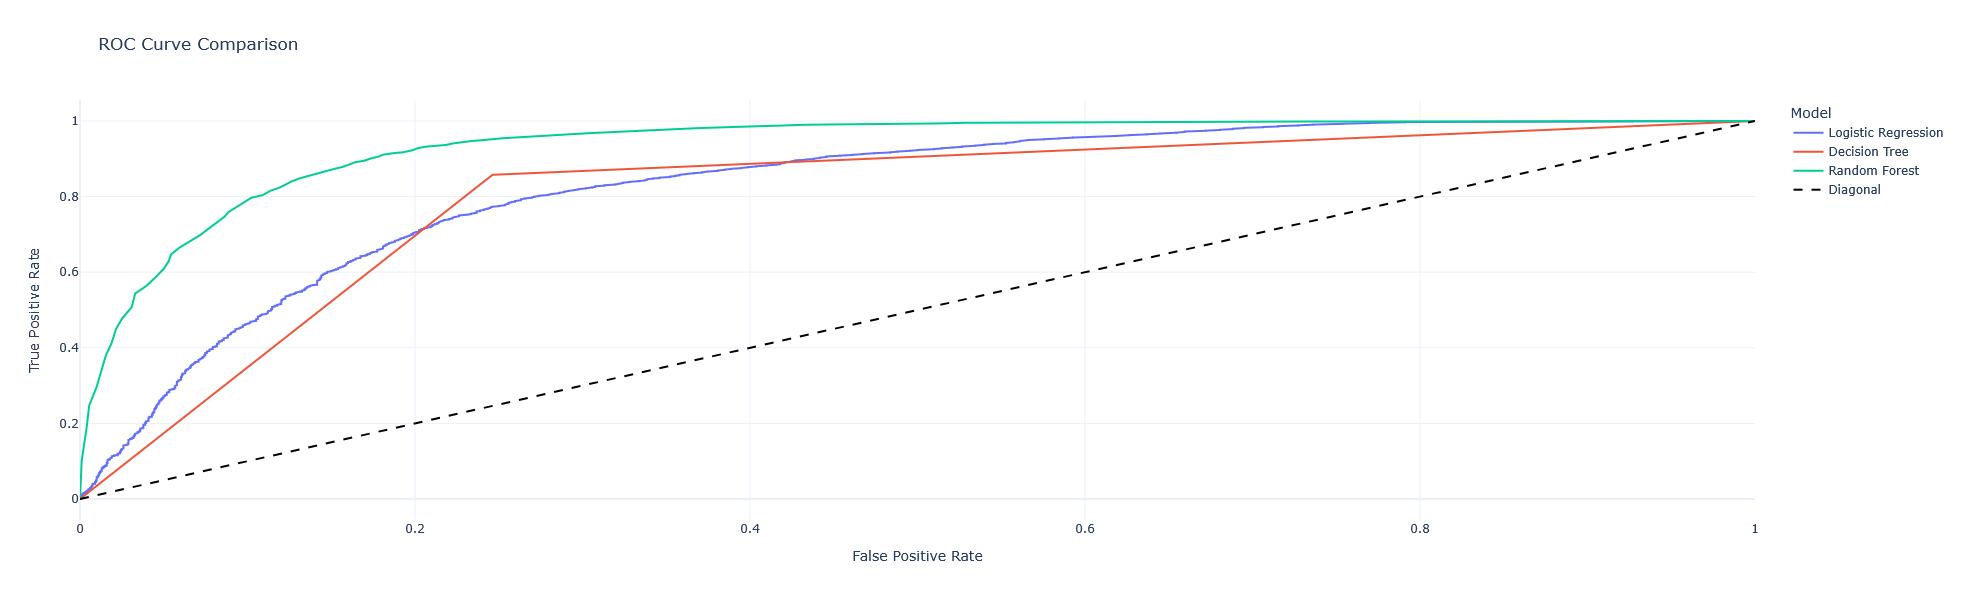

In [326]:
plot_roc_curves(y_test, probs, models)

**Random Forest clearly outperforms the other models with a steeper ROC curve, meaning it does a better job separating Gamma and Hadron classes.**

### **11. Feature Significance - Random Forest**

In [330]:
def plot_feature_importance(model, feature_names):
    """
    Creates a horizontal bar chart of feature importances from a trained Random Forest model.
    
    """
    importances = model.feature_importances_
    features_sorted = np.argsort(importances)[::-1]
    sorted_names = feature_names[features_sorted]
    sorted_importances = importances[features_sorted]
    importance_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h',
                 title="Feature Importances (Random Forest)")
    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False,
                      width=800, height=500)
    return fig

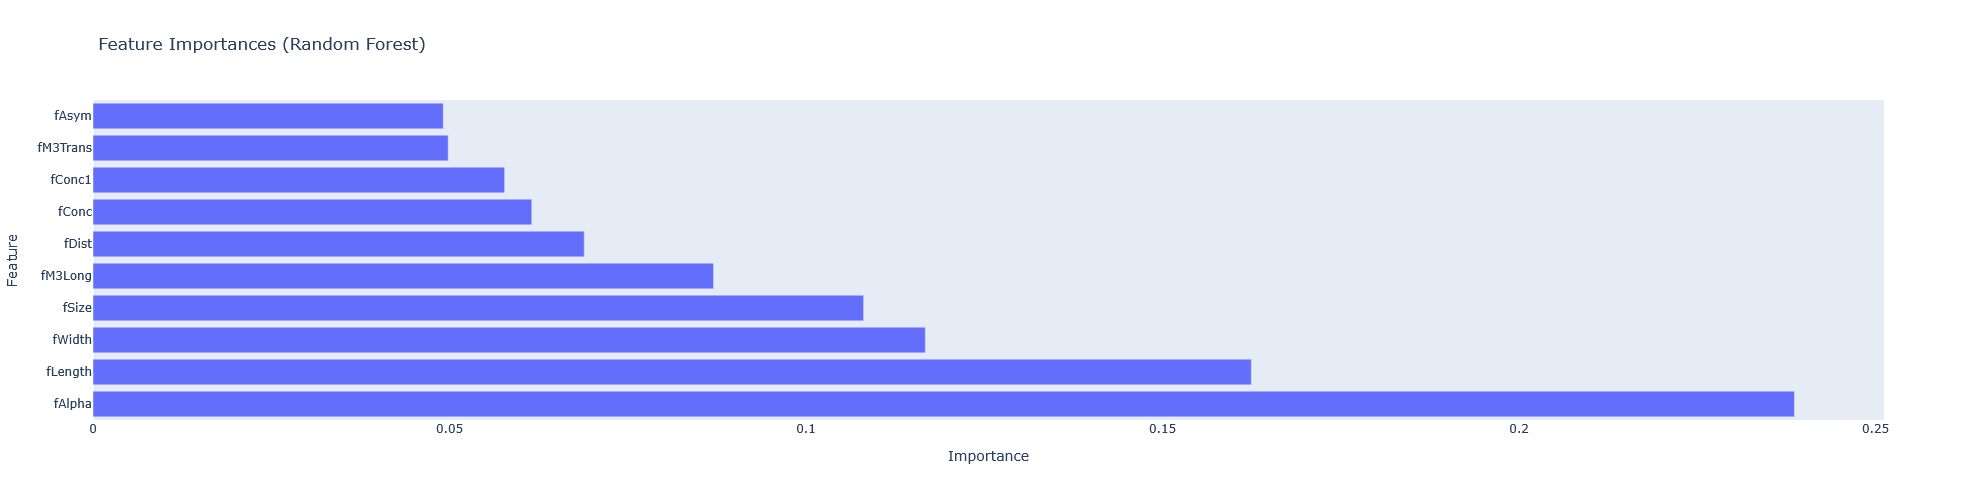

In [332]:
plot_feature_importance(models["Random Forest"], X.columns)

**The feature <u>fAlpha</u> stands out as the most important in predicting Gamma vs Hadron, meaning it's the MVP the Random Forest relies on most for decision-making.**

# **Summary**

### Random Forest outshined the logistic regression baseline by striking the best balance between accuracy and reliability in classifying gamma vs hadron events. Its ability to minimize false positives makes it a strong choice for this kind of astrophysical data.